# Capacity allocation

In [2]:
!python3 -m pip install -e /Users/uclm/PycharmProjects/robin

Obtaining file:///Users/uclm/PycharmProjects/robin
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for robin (pyproject.toml) ... done
  Created wheel for robin: filename=robin-0.0.post1.dev693+g09e8b4e.d20250212-0.editable-py3-none-any.whl size=4803 sha256=15233c5a2f479b097555f7d44556927c5af1aed9b1de5fa46a92bb2676522d34
  Stored in directory: /private/var/folders/dc/fy76phnd5ljbdtj9v4jgnyjh0000gp/T/pip-ephem-wheel-cache-4kx4dz03/wheels/95/66/8c/f86d0fe2002dbd257594ab2243d170e549be6e8881f194a7b6
Successfully built robin
  Attempting uninstall: robin
    Found existing installation: robin 0.0.post1.dev690+ge9df025
    Uninstalling robin-0.0.post1.dev690+ge9df025:
      Successfully uninstalled robin-0.0.post1.dev690+ge9df025

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run:

## 0. Load libraries

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution
from src.timetabling_problem import MPTT

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from mealpy.evolutionary_based import GA
from mealpy import IntegerVar
from pathlib import Path
import shutil
from typing import Any, List, Mapping, Tuple, Union

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [15]:
frame_capacity = {'1': 0.6, '2': 0.30, '3': 0.1, '4': 0}

n_services = 27
n_services_by_ru = {ru: round(cap * n_services) for ru, cap in frame_capacity.items()}

n_services_by_ru

{'1': 16, '2': 8, '3': 3, '4': 0}

In [16]:
seed = 21

if generator_config_path:
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services_by_ru=n_services_by_ru,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 27


In [17]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)
print(tsp_df)

     Number of Services
RU1                  16
RU2                   8
RU3                   3


In [18]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  27


In [19]:
n_services = sum(tsp_df["Number of Services"].values)

services_by_ru = {}
for service in revenue_behavior:
    if revenue_behavior[service]['ru'] not in services_by_ru:
        services_by_ru[revenue_behavior[service]['ru']] = 1
    else:
        services_by_ru[revenue_behavior[service]['ru']] += 1

services_by_ru = {f"RU{k}": v for k, v in services_by_ru.items()}
print(services_by_ru)

frame_capacity = {ru: services_by_ru[ru] / n_services * 100 for ru in services_by_ru}
print(frame_capacity)

{'RU1': 16, 'RU2': 8, 'RU3': 3}
{'RU1': 59.25925925925925, 'RU2': 29.629629629629626, 'RU3': 11.11111111111111}


/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


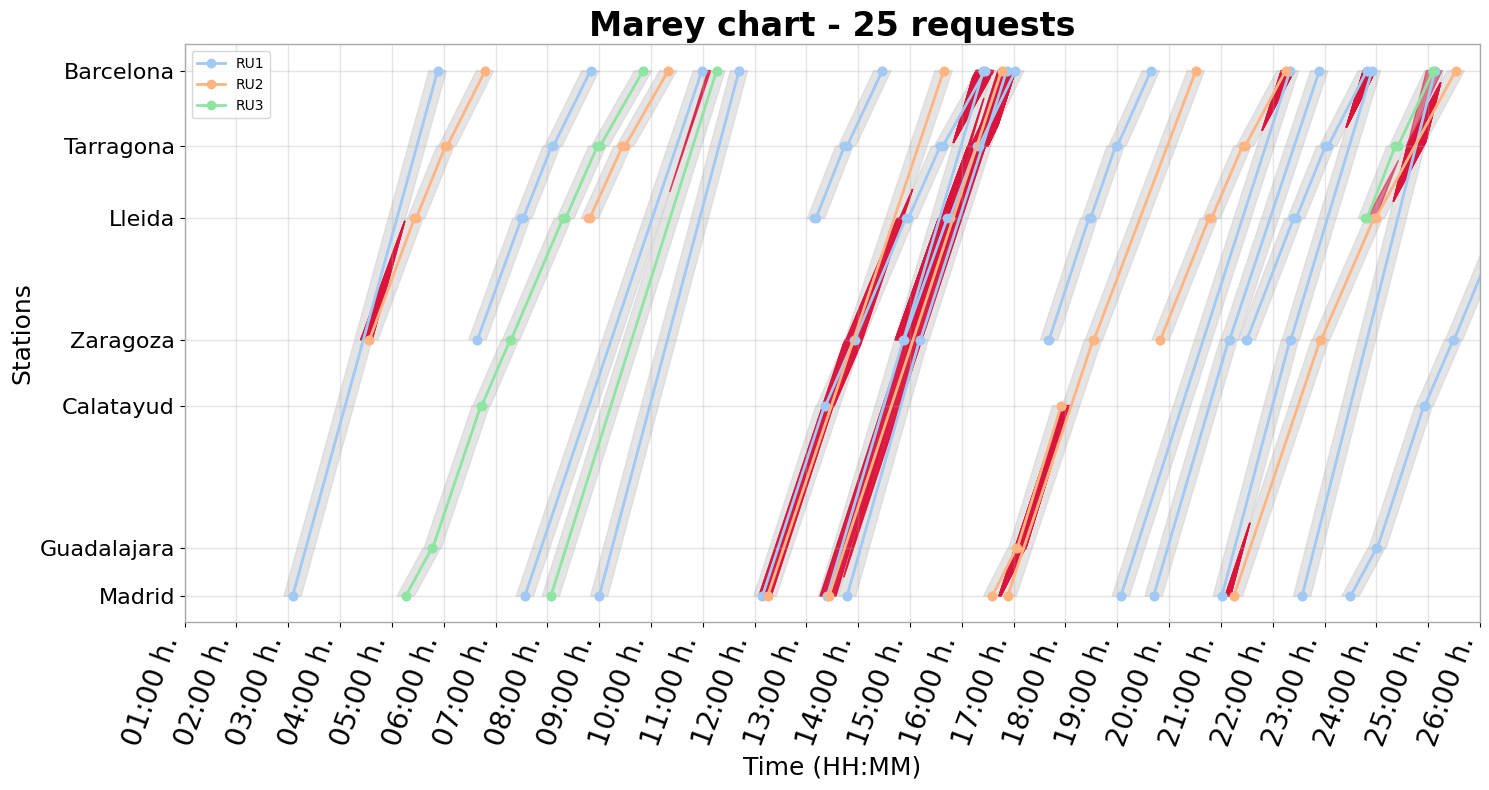

In [20]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Marey chart - 25 requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [78]:
def jains_fairness_index(bool_scheduled: List[bool],
                         revenue,
                         services_by_ru,
) -> Tuple[float, Mapping[Any, float]]:
    """
    Calculate the weighted Jain's fairness index based on the scheduled resources and capacities.

    Args:
        bool_scheduled: Boolean list indicating which services are scheduled.
        capacities: Mapping of capacity values for each RU.

    Returns:
        A tuple containing:
          - The Jain's fairness index (float).
          - A mapping of resource-to-capacity ratios.
    """
    scheduled = {}
    for service, scheduled_flag in zip(revenue.keys(), bool_scheduled):
        ru = revenue[service]["ru"]
        scheduled[ru] = scheduled.get(ru, 0) + (revenue[service]["importance"] if scheduled_flag else 0)

    ratios = scheduled
    alpha = 10  # Por ejemplo, para aumentar la sensibilidad
    ratios = {ru: (ratio ** alpha) for ru, ratio in ratios.items()}
    print("Ratios: ", ratios)

    n = len(ratios)
    sum_ratios = sum(ratios.values())
    sum_squares = sum(x ** 2 for x in ratios.values())
    if sum_squares == 0:
        return 0.0, ratios
    fairness = (sum_ratios ** 2) / (n * sum_squares)
    return fairness, scheduled

jains_fairness_index([True, True, False, True, True, False, False],  # Servicios planificados
                     {'s1': {'ru': '1', 'importance': 0.2},  # Para cada servicio, información de su RU y su importancia para ese RU
                      's2': {'ru': '1', 'importance': 0.3},
                      's3': {'ru': '1', 'importance': 0.5},
                      's4': {'ru': '2', 'importance': 0.5},
                      's5': {'ru': '2', 'importance': 0.4},
                      's6': {'ru': '2', 'importance': 0.3},
                      's7': {'ru': '2', 'importance': 0.1},
                      },
                      {'1': 3, '2': 4}  # Número de servicios que podía solicitar cada RU
                     )

Ratios:  {'1': 0.02824752489999998, '2': 0.006046617600000009}


(0.7046796949777117, {'1': 0.7, '2': 0.6000000000000001})

In [80]:
# ------------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------------
runs = 5
epochs = 100
pop_size = 50
seed_initializer = 29
fair_indices = ["Jain", "Revenue"]

# ------------------------------------------------------------------------------
# Data Collection Containers
# ------------------------------------------------------------------------------
# Lists to accumulate history and population data from each run.
history_data = []
population_data = []

# ------------------------------------------------------------------------------
# 1. Iterate over Algorithms and Runs
# ------------------------------------------------------------------------------
for fair_index in fair_indices:
    # Reset random seed for reproducibility per algorithm
    np.random.seed(seed_initializer)
    print(f"Running {fair_index}")

    mptt = MPTT(requested_schedule=requested_schedule,
                revenue_behavior=revenue_behavior,
                line=line,
                safe_headway=10,
                fair_index=fair_index)

    # ------------------------------------------------------------------------------
    # 0. Problem Formulation
    # ------------------------------------------------------------------------------
    lb, ub = zip(*mptt.boundaries.real)
    problem = {
        "obj_func": mptt.objective_function,
        "bounds": IntegerVar(lb=lb, ub=ub),
        "minmax": "max",
        "save_population": False
    }

    for run in range(1, runs + 1):
        print(f"\tRun: {run}")
        run_seed = np.random.randint(0, 1000)

        # Initialize and run the optimizer with appropriate parameters.
        optimizer = GA.BaseGA(epoch=epochs, pop_size=pop_size)
        optimizer.solve(problem, seed=run_seed)

        # ---------------------------
        # Build History Data
        # ---------------------------
        for iteration, data in enumerate(optimizer.history.list_global_best):
            # Update schedule so that the latest heuristic schedule is available.
            mptt.update_schedule(data.solution)

            # Build a dictionary for this iteration
            history_data.append({
                "Run": run,
                "FairIndex": fair_index,
                "Iteration": iteration,
                "Fitness": data.target.fitness,
                "Revenue": mptt.get_revenue(Solution(real=data.solution,
                                                     discrete=mptt.get_heuristic_schedule_new() if fair_index != "Revenue" else mptt.get_heuristic_schedule_old())),
                "ExecutionTime": optimizer.history.list_epoch_time[iteration],
                "Discrete": mptt.get_heuristic_schedule_new() if fair_index != "Revenue" else mptt.get_heuristic_schedule_old(),
                "Real": data.solution,
                "Diversity": optimizer.history.list_diversity[iteration],
                "Exploitation": optimizer.history.list_exploitation[iteration],
                "Exploration": optimizer.history.list_exploration[iteration],
            })

        # ---------------------------
        # Build Population Data
        # ---------------------------
        for iteration, pop_epoch in enumerate(optimizer.history.list_population):
            real_solutions = []
            discrete_solutions = []
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real_solutions.append(individual.solution)
                discrete_solutions.append(mptt.get_heuristic_schedule_new() if fair_index else mptt.get_heuristic_schedule_old())

            # Create a row dictionary for the population at this iteration.
            """
            pop_row = {
                "Run": run,
                "FairIndex": fair_index,
                "Iteration": iteration,
            }
            # Add the real solution columns.
            for idx, sol in enumerate(real_solutions):
                pop_row[f"real_{idx}"] = sol
            # Add the discrete solution columns.
            for idx, sol in enumerate(discrete_solutions):
                pop_row[f"discrete_{idx}"] = sol

            population_data.append(pop_row)
            """

# ------------------------------------------------------------------------------
# 2. Build Final DataFrames
# ------------------------------------------------------------------------------
# Create the history DataFrame from the list of dictionaries.
df_history = pd.DataFrame(history_data)
# Optionally, enforce a specific column order:
df_history = df_history[[
    "Run", "FairIndex", "Iteration", "Fitness", "Revenue", "ExecutionTime",
    "Discrete", "Real", "Diversity", "Exploitation", "Exploration"
]]

"""
# For population data, build the DataFrame only if data was collected.
if population_data:
    df_population = pd.DataFrame(population_data)

    # Define the desired column order: Run, Algo, Iteration, then real and discrete columns.
    real_cols = [f"real_{i}" for i in range(pop_size)]
    discrete_cols = [f"discrete_{i}" for i in range(pop_size)]
    columns_order = ["Run", "FairIndex", "Iteration"] + real_cols + discrete_cols

    # Reindex to enforce the column order. Missing columns will be added as NaN.
    df_population = df_population.reindex(columns=columns_order)
else:
    df_population = pd.DataFrame()
"""

2025/02/12 01:36:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Jain
	Run: 1


2025/02/12 01:36:55 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1797.6365131433186, Global best: 1797.6365131433186, Runtime: 0.28479 seconds
2025/02/12 01:36:55 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2005.014759585415, Global best: 2005.014759585415, Runtime: 0.29153 seconds
2025/02/12 01:36:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2239.0101001560047, Global best: 2239.0101001560047, Runtime: 0.28813 seconds
2025/02/12 01:36:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2185.7474403198867, Global best: 2239.0101001560047, Runtime: 0.29480 seconds
2025/02/12 01:36:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2402.5212470845313, Global best: 2402.5212470845313, Runtime: 0.28711 seconds
2025/02/12 01:36:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 2


2025/02/12 01:37:24 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2117.756821632146, Global best: 2117.756821632146, Runtime: 0.27679 seconds
2025/02/12 01:37:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2168.862351324084, Global best: 2168.862351324084, Runtime: 0.28327 seconds
2025/02/12 01:37:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2114.1097919303415, Global best: 2168.862351324084, Runtime: 0.27757 seconds
2025/02/12 01:37:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2412.7329176843186, Global best: 2412.7329176843186, Runtime: 0.28087 seconds
2025/02/12 01:37:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2546.4065066550615, Global best: 2546.4065066550615, Runtime: 0.27606 seconds
2025/02/12 01:37:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

	Run: 3


2025/02/12 01:37:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1696.7587359128154, Global best: 1996.9223960525103, Runtime: 0.27920 seconds
2025/02/12 01:37:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2206.973858291987, Global best: 2206.973858291987, Runtime: 0.27915 seconds
2025/02/12 01:37:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2379.617777640596, Global best: 2379.617777640596, Runtime: 0.27470 seconds
2025/02/12 01:37:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2628.9792640424043, Global best: 2628.9792640424043, Runtime: 0.28066 seconds
2025/02/12 01:37:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2582.332243813665, Global best: 2628.9792640424043, Runtime: 0.27565 seconds
2025/02/12 01:37:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

	Run: 4


2025/02/12 01:38:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2261.6781609418003, Global best: 2261.6781609418003, Runtime: 0.27820 seconds
2025/02/12 01:38:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2262.853557718943, Global best: 2262.853557718943, Runtime: 0.27856 seconds
2025/02/12 01:38:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2429.0416563429194, Global best: 2429.0416563429194, Runtime: 0.27775 seconds
2025/02/12 01:38:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2606.6394626455294, Global best: 2606.6394626455294, Runtime: 0.27863 seconds
2025/02/12 01:38:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, Current best: 2426.3925726193675, Global best: 2606.6394626455294, Runtime: 0.27830 seconds
2025/02/12 01:38:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 5


2025/02/12 01:38:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1713.487915491512, Global best: 1833.3818517839263, Runtime: 0.27971 seconds
2025/02/12 01:38:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2146.1714334330613, Global best: 2146.1714334330613, Runtime: 0.27867 seconds
2025/02/12 01:38:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1866.9837067153205, Global best: 2146.1714334330613, Runtime: 0.28023 seconds
2025/02/12 01:38:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1984.1991251893471, Global best: 2146.1714334330613, Runtime: 0.28074 seconds
2025/02/12 01:38:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2029.1329627141606, Global best: 2146.1714334330613, Runtime: 0.27964 seconds
2025/02/12 01:38:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P,

Running Revenue
	Run: 1


2025/02/12 01:39:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2180.2127268992685, Global best: 2180.2127268992685, Runtime: 0.26964 seconds
2025/02/12 01:39:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2777.937623507743, Global best: 2777.937623507743, Runtime: 0.26848 seconds
2025/02/12 01:39:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2748.518972269156, Global best: 2777.937623507743, Runtime: 0.26884 seconds
2025/02/12 01:39:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3052.5505304259336, Global best: 3052.5505304259336, Runtime: 0.26930 seconds
2025/02/12 01:39:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3267.8729082243044, Global best: 3267.8729082243044, Runtime: 0.27014 seconds
2025/02/12 01:39:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 2


2025/02/12 01:39:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2322.842831213861, Global best: 2322.842831213861, Runtime: 0.26850 seconds
2025/02/12 01:39:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2632.4698755353047, Global best: 2632.4698755353047, Runtime: 0.26857 seconds
2025/02/12 01:39:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2909.9867769324296, Global best: 2909.9867769324296, Runtime: 0.27057 seconds
2025/02/12 01:39:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2931.888264066205, Global best: 2931.888264066205, Runtime: 0.26965 seconds
2025/02/12 01:39:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3093.9818910780386, Global best: 3093.9818910780386, Runtime: 0.27272 seconds
2025/02/12 01:39:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 3


2025/02/12 01:40:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2617.390024205773, Global best: 2617.390024205773, Runtime: 0.27497 seconds
2025/02/12 01:40:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2639.9266884061635, Global best: 2639.9266884061635, Runtime: 0.27126 seconds
2025/02/12 01:40:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3037.962046992245, Global best: 3037.962046992245, Runtime: 0.27830 seconds
2025/02/12 01:40:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3128.7178162176688, Global best: 3128.7178162176688, Runtime: 0.29644 seconds
2025/02/12 01:40:17 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3341.5436204191556, Global best: 3341.5436204191556, Runtime: 0.27946 seconds
2025/02/12 01:40:17 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 4


2025/02/12 01:40:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2858.0877472580023, Global best: 2858.0877472580023, Runtime: 0.26878 seconds
2025/02/12 01:40:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2607.289347477653, Global best: 2858.0877472580023, Runtime: 0.27489 seconds
2025/02/12 01:40:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2705.069746330644, Global best: 2858.0877472580023, Runtime: 0.27125 seconds
2025/02/12 01:40:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3135.3359378129026, Global best: 3135.3359378129026, Runtime: 0.27391 seconds
2025/02/12 01:40:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3358.097149917468, Global best: 3358.097149917468, Runtime: 0.27256 seconds
2025/02/12 01:40:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 5


2025/02/12 01:41:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2763.6820094751797, Global best: 2763.6820094751797, Runtime: 0.27027 seconds
2025/02/12 01:41:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2837.1595435677214, Global best: 2837.1595435677214, Runtime: 0.27271 seconds
2025/02/12 01:41:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3055.7473974905097, Global best: 3055.7473974905097, Runtime: 0.27253 seconds
2025/02/12 01:41:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3327.9191358564417, Global best: 3327.9191358564417, Runtime: 0.27093 seconds
2025/02/12 01:41:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3330.879035233769, Global best: 3330.879035233769, Runtime: 0.27232 seconds
2025/02/12 01:41:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

'\n# For population data, build the DataFrame only if data was collected.\nif population_data:\n    df_population = pd.DataFrame(population_data)\n\n    # Define the desired column order: Run, Algo, Iteration, then real and discrete columns.\n    real_cols = [f"real_{i}" for i in range(pop_size)]\n    discrete_cols = [f"discrete_{i}" for i in range(pop_size)]\n    columns_order = ["Run", "FairIndex", "Iteration"] + real_cols + discrete_cols\n\n    # Reindex to enforce the column order. Missing columns will be added as NaN.\n    df_population = df_population.reindex(columns=columns_order)\nelse:\n    df_population = pd.DataFrame()\n'

## 2. Results analysis

In [81]:
reports_path = Path('../reports/mealpy/')

In [82]:
df_history.to_csv(reports_path / 'df_history_equity.csv', sep=";", index=False)

In [11]:
df_population.to_csv(reports_path / 'df_population_equity.csv', sep=";", index=False)

In [86]:
df_history = pd.read_csv(reports_path / 'df_history_equity.csv', sep=";")
#df_population = pd.read_csv(reports_path / 'df_population_equity.csv', sep=";")

In [87]:
df_history

,Run,FairIndex,Iteration,Fitness,Revenue,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Jain,0,1797.636513,2046.494885,0.284786,[ True True False True True False False Tr...,[1070. 1112. 1142. 1379. 1446. 1498. 1537. 159...,12.952698,0.000000,100.000000
1,1,Jain,1,2005.014760,2282.581835,0.291526,[ True True False True True False False Tr...,[1070. 1112. 1142. 1379. 1446. 1499. 1537. 159...,10.888254,15.938335,84.061665
2,1,Jain,2,2239.010100,2353.556000,0.288130,[ True True True True True False True Fal...,[1044. 1112. 1148. 1379. 1446. 1499. 1537. 159...,9.666349,25.371927,74.628073
3,1,Jain,3,2239.010100,2353.556000,0.294797,[ True True True True True False True Fal...,[1044. 1112. 1148. 1379. 1446. 1499. 1537. 159...,8.333968,35.658440,64.341560
4,1,Jain,4,2402.521247,2402.775628,0.287109,[ True True True True True False True Fal...,[1044. 1112. 1144. 1379. 1447. 1503. 1537. 159...,6.657460,48.601750,51.398250
...,...,...,...,...,...,...,...,...,...,...,...
995,5,Revenue,95,4846.180223,4846.180223,0.276908,[ True True True True False True True Fal...,[1058. 1112. 1143. 1433. 1448. 1497. 1536. 159...,1.555238,87.594956,12.405044
996,5,Revenue,96,4865.984860,4865.984860,0.275384,[ True True True True False True True Fal...,[1058. 1112. 1143. 1433. 1448. 1497. 1536. 159...,1.342222,89.294034,10.705966
997,5,Revenue,97,4865.984860,4865.984860,0.276690,[ True True True True False True True Fal...,[1058. 1112. 1143. 1433. 1448. 1497. 1536. 159...,1.230476,90.185354,9.814646
998,5,Revenue,98,4865.984860,4865.984860,0.277517,[ True True True True False True True Fal...,[1058. 1112. 1143. 1433. 1448. 1497. 1536. 159...,1.220952,90.261319,9.738681


In [49]:
df_population

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,NaN,0,[1034. 1116. 1147. 1350. 1446. 1496. 1534. 159...,[1072. 1112. 1145. 1356. 1445. 1502. 1535. 159...,[1105. 1116. 1143. 1459. 1450. 1505. 1536. 159...,[1041. 1109. 1140. 1385. 1446. 1500. 1534. 159...,[1072. 1113. 1142. 1350. 1446. 1496. 1535. 159...,[1029. 1116. 1145. 1469. 1443. 1502. 1534. 159...,[1072. 1116. 1145. 1350. 1446. 1496. 1535. 159...,...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True False False False Tr...
1,1,NaN,1,[1072. 1115. 1145. 1356. 1446. 1502. 1535. 159...,[1034. 1116. 1147. 1350. 1445. 1496. 1533. 159...,[1029. 1115. 1147. 1356. 1445. 1502. 1533. 159...,[1034. 1116. 1145. 1469. 1443. 1502. 1534. 159...,[1029. 1116. 1148. 1469. 1446. 1498. 1535. 159...,[1089. 1113. 1145. 1350. 1445. 1501. 1537. 159...,[1024. 1113. 1144. 1350. 1446. 1499. 1535. 159...,...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...
2,1,NaN,2,[1034. 1112. 1145. 1356. 1450. 1496. 1530. 159...,[1072. 1116. 1145. 1379. 1444. 1496. 1532. 159...,[1034. 1112. 1144. 1356. 1446. 1496. 1530. 159...,[1024. 1113. 1145. 1350. 1444. 1499. 1535. 159...,[1029. 1113. 1145. 1356. 1445. 1496. 1538. 159...,[1034. 1112. 1148. 1379. 1444. 1499. 1530. 159...,[1050. 1110. 1143. 1350. 1445. 1503. 1537. 159...,...,[False True True True False False False Tr...,[False True True True True True False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True True False Tr...,[False True True True False False False Tr...,[False True True True True True False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...
3,1,NaN,3,[1029. 1116. 1148. 1350. 1445. 1496. 1535. 159...,[1072. 1116. 1145. 1350. 1450. 1501. 1537. 159...,[1029. 1112. 1145. 1469. 1446. 1496. 1537. 159...,[1072. 1113. 1145. 1356. 1444. 1502. 1530. 159...,[1072. 1112. 1145. 1356. 1444. 1502. 1534. 159...,[1072. 1113. 1141. 1350. 1445. 1502. 1530. 159...,[1034. 1112. 1145. 1356. 1450. 1496. 1530. 159...,...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...
4,1,NaN,4,[1029. 1116. 1147. 1350. 1445. 1501. 1530. 159...,[1034. 1113. 1145. 1350. 1446. 1501. 1534. 159...,[1029. 1113. 1145. 1350. 1446. 1501. 1531. 159...,[1034. 1116. 1145. 1350. 1445. 1501. 1535. 159...,[1029. 1116. 1145. 1350. 1446. 1501. 1535. 159...,[1034. 1112. 1145. 1379. 1445. 1499. 1532. 159...,[1034. 1116. 1147. 1379. 1445. 1502. 1535. 159...,...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False Fals

In [88]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,Revenue,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Jain,0,1797.636513,2046.494885,0.284786,[ True True False True True False False Tr...,"[1070, 1112, 1142, 1379, 1446, 1498, 1537, 159...",12.952698,0.000000,100.000000
1,1,Jain,1,2005.014760,2282.581835,0.291526,[ True True False True True False False Tr...,"[1070, 1112, 1142, 1379, 1446, 1499, 1537, 159...",10.888254,15.938335,84.061665
2,1,Jain,2,2239.010100,2353.556000,0.288130,[ True True True True True False True Fal...,"[1044, 1112, 1148, 1379, 1446, 1499, 1537, 159...",9.666349,25.371927,74.628073
3,1,Jain,3,2239.010100,2353.556000,0.294797,[ True True True True True False True Fal...,"[1044, 1112, 1148, 1379, 1446, 1499, 1537, 159...",8.333968,35.658440,64.341560
4,1,Jain,4,2402.521247,2402.775628,0.287109,[ True True True True True False True Fal...,"[1044, 1112, 1144, 1379, 1447, 1503, 1537, 159...",6.657460,48.601750,51.398250


In [89]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,Revenue,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Jain,0,1797.636513,2046.494885,0.284786,"[True, True, False, True, True, False, False, ...","[1070, 1112, 1142, 1379, 1446, 1498, 1537, 159...",12.952698,0.000000,100.000000
1,1,Jain,1,2005.014760,2282.581835,0.291526,"[True, True, False, True, True, False, False, ...","[1070, 1112, 1142, 1379, 1446, 1499, 1537, 159...",10.888254,15.938335,84.061665
2,1,Jain,2,2239.010100,2353.556000,0.288130,"[True, True, True, True, True, False, True, Fa...","[1044, 1112, 1148, 1379, 1446, 1499, 1537, 159...",9.666349,25.371927,74.628073
3,1,Jain,3,2239.010100,2353.556000,0.294797,"[True, True, True, True, True, False, True, Fa...","[1044, 1112, 1148, 1379, 1446, 1499, 1537, 159...",8.333968,35.658440,64.341560
4,1,Jain,4,2402.521247,2402.775628,0.287109,"[True, True, True, True, True, False, True, Fa...","[1044, 1112, 1144, 1379, 1447, 1503, 1537, 159...",6.657460,48.601750,51.398250


In [52]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,NaN,0,"[1034.0, 1116.0, 1147.0, 1350.0, 1446.0, 1496....","[1072.0, 1112.0, 1145.0, 1356.0, 1445.0, 1502....","[1105.0, 1116.0, 1143.0, 1459.0, 1450.0, 1505....","[1041.0, 1109.0, 1140.0, 1385.0, 1446.0, 1500....","[1072.0, 1113.0, 1142.0, 1350.0, 1446.0, 1496....","[1029.0, 1116.0, 1145.0, 1469.0, 1443.0, 1502....","[1072.0, 1116.0, 1145.0, 1350.0, 1446.0, 1496....",...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True False False False Tr...
1,1,NaN,1,"[1072.0, 1115.0, 1145.0, 1356.0, 1446.0, 1502....","[1034.0, 1116.0, 1147.0, 1350.0, 1445.0, 1496....","[1029.0, 1115.0, 1147.0, 1356.0, 1445.0, 1502....","[1034.0, 1116.0, 1145.0, 1469.0, 1443.0, 1502....","[1029.0, 1116.0, 1148.0, 1469.0, 1446.0, 1498....","[1089.0, 1113.0, 1145.0, 1350.0, 1445.0, 1501....","[1024.0, 1113.0, 1144.0, 1350.0, 1446.0, 1499....",...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...
2,1,NaN,2,"[1034.0, 1112.0, 1145.0, 1356.0, 1450.0, 1496....","[1072.0, 1116.0, 1145.0, 1379.0, 1444.0, 1496....","[1034.0, 1112.0, 1144.0, 1356.0, 1446.0, 1496....","[1024.0, 1113.0, 1145.0, 1350.0, 1444.0, 1499....","[1029.0, 1113.0, 1145.0, 1356.0, 1445.0, 1496....","[1034.0, 1112.0, 1148.0, 1379.0, 1444.0, 1499....","[1050.0, 1110.0, 1143.0, 1350.0, 1445.0, 1503....",...,[False True True True False False False Tr...,[False True True True True True False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True True False Tr...,[False True True True False False False Tr...,[False True True True True True False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...
3,1,NaN,3,"[1029.0, 1116.0, 1148.0, 1350.0, 1445.0, 1496....","[1072.0, 1116.0, 1145.0, 1350.0, 1450.0, 1501....","[1029.0, 1112.0, 1145.0, 1469.0, 1446.0, 1496....","[1072.0, 1113.0, 1145.0, 1356.0, 1444.0, 1502....","[1072.0, 1112.0, 1145.0, 1356.0, 1444.0, 1502....","[1072.0, 1113.0, 1141.0, 1350.0, 1445.0, 1502....","[1034.0, 1112.0, 1145.0, 1356.0, 1450.0, 1496....",...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...
4,1,NaN,4,"[1029.0, 1116.0, 1147.0, 1350.0, 1445.0, 1501....","[1034.0, 1113.0, 1145.0, 1350.0, 1446.0, 1501....","[1029.0, 1113.0, 1145.0, 1350.0, 1446.0, 1501....","[1034.0, 1116.0, 1145.0, 1350.0, 1445.0, 1501....","[1029.0, 1116.0, 1145.0, 1350.0, 1446.0, 1501....","[1034.0, 1112.0, 1145.0, 1379.0, 1445.0, 1499....","[1034.0, 1116.0, 1147.0, 1379.0, 1445.0, 1502....",...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True 

In [61]:
# Replace FairIndex NaN values with "Revenue"
df_history['FairIndex'] = df_history['FairIndex'].fillna("Revenue")
df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,1910.207889,0.260015,"[False, True, True, True, True, False, False, ...","[1029, 1113, 1148, 1469, 1445, 1498, 1537, 159...",12.454426,0.000000,100.000000
1,1,Revenue,1,2417.397515,0.261735,"[False, True, True, True, True, False, False, ...","[1029, 1113, 1148, 1379, 1445, 1499, 1538, 159...",10.107541,18.843785,81.156215
2,1,Revenue,2,2445.273185,0.261960,"[False, True, True, True, True, False, False, ...","[1034, 1116, 1147, 1350, 1445, 1501, 1535, 159...",9.456721,24.069394,75.930606
3,1,Revenue,3,2445.273185,0.256549,"[False, True, True, True, True, False, False, ...","[1034, 1116, 1147, 1350, 1445, 1501, 1535, 159...",8.597377,30.969304,69.030696
4,1,Revenue,4,2811.451538,0.256231,"[False, True, True, True, True, False, False, ...","[1034, 1116, 1145, 1350, 1445, 1501, 1535, 159...",7.175738,42.384036,57.615964


In [53]:
# Replace FairIndex NaN values with "Revenue"
df_population['FairIndex'] = df_population['FairIndex'].fillna("Revenue")
df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1034.0, 1116.0, 1147.0, 1350.0, 1446.0, 1496....","[1072.0, 1112.0, 1145.0, 1356.0, 1445.0, 1502....","[1105.0, 1116.0, 1143.0, 1459.0, 1450.0, 1505....","[1041.0, 1109.0, 1140.0, 1385.0, 1446.0, 1500....","[1072.0, 1113.0, 1142.0, 1350.0, 1446.0, 1496....","[1029.0, 1116.0, 1145.0, 1469.0, 1443.0, 1502....","[1072.0, 1116.0, 1145.0, 1350.0, 1446.0, 1496....",...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True False False False Tr...
1,1,Revenue,1,"[1072.0, 1115.0, 1145.0, 1356.0, 1446.0, 1502....","[1034.0, 1116.0, 1147.0, 1350.0, 1445.0, 1496....","[1029.0, 1115.0, 1147.0, 1356.0, 1445.0, 1502....","[1034.0, 1116.0, 1145.0, 1469.0, 1443.0, 1502....","[1029.0, 1116.0, 1148.0, 1469.0, 1446.0, 1498....","[1089.0, 1113.0, 1145.0, 1350.0, 1445.0, 1501....","[1024.0, 1113.0, 1144.0, 1350.0, 1446.0, 1499....",...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...
2,1,Revenue,2,"[1034.0, 1112.0, 1145.0, 1356.0, 1450.0, 1496....","[1072.0, 1116.0, 1145.0, 1379.0, 1444.0, 1496....","[1034.0, 1112.0, 1144.0, 1356.0, 1446.0, 1496....","[1024.0, 1113.0, 1145.0, 1350.0, 1444.0, 1499....","[1029.0, 1113.0, 1145.0, 1356.0, 1445.0, 1496....","[1034.0, 1112.0, 1148.0, 1379.0, 1444.0, 1499....","[1050.0, 1110.0, 1143.0, 1350.0, 1445.0, 1503....",...,[False True True True False False False Tr...,[False True True True True True False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True True False Tr...,[False True True True False False False Tr...,[False True True True True True False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...
3,1,Revenue,3,"[1029.0, 1116.0, 1148.0, 1350.0, 1445.0, 1496....","[1072.0, 1116.0, 1145.0, 1350.0, 1450.0, 1501....","[1029.0, 1112.0, 1145.0, 1469.0, 1446.0, 1496....","[1072.0, 1113.0, 1145.0, 1356.0, 1444.0, 1502....","[1072.0, 1112.0, 1145.0, 1356.0, 1444.0, 1502....","[1072.0, 1113.0, 1141.0, 1350.0, 1445.0, 1502....","[1034.0, 1112.0, 1145.0, 1356.0, 1450.0, 1496....",...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True False False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...,[False True True True True False False Tr...
4,1,Revenue,4,"[1029.0, 1116.0, 1147.0, 1350.0, 1445.0, 1501....","[1034.0, 1113.0, 1145.0, 1350.0, 1446.0, 1501....","[1029.0, 1113.0, 1145.0, 1350.0, 1446.0, 1501....","[1034.0, 1116.0, 1145.0, 1350.0, 1445.0, 1501....","[1029.0, 1116.0, 1145.0, 1350.0, 1446.0, 1501....","[1034.0, 1112.0, 1145.0, 1379.0, 1445.0, 1499....","[1034.0, 1116.0, 1147.0, 1379.0, 1445.0, 1502....",...,[False True True True True False False Tr...,[False True True True True False Fals

In [55]:
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

# Create dataframe with fitness values for each individual of the population
fair_indices = ["Revenue", "Jain", "Gini", "Atkinson"]
df_pop = df_population[df_population['FairIndex'].isin(fair_indices)]

set_filtered_algos = set(df_pop["FairIndex"])
print(f"Filtered fair indices: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_fair_index = row['FairIndex']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_fair_index != previous_algo:
        print(f"Processing new combination: Run = {current_run}, FairIndex = {current_fair_index}")
        previous_run, previous_algo = current_run, current_fair_index

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

Filtered fair indices: {'Atkinson', 'Revenue', 'Gini', 'Jain'}
Processing new combination: Run = 1, FairIndex = Revenue
Processing new combination: Run = 2, FairIndex = Revenue
Processing new combination: Run = 3, FairIndex = Revenue
Processing new combination: Run = 4, FairIndex = Revenue
Processing new combination: Run = 5, FairIndex = Revenue
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkin

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,real_40,real_41,real_42,real_43,real_44,real_45,real_46,real_47,real_48,real_49
0,1,Revenue,0,1440.668835,1471.576123,1243.013178,1035.583743,937.374972,1612.059234,1609.864292,...,1587.402263,1436.281128,600.205405,1301.687763,1285.541105,1845.990852,833.086929,950.791346,1375.058001,1267.662394
1,1,Revenue,1,1485.450741,1782.454401,1547.981742,1365.518959,1529.289614,1649.00702,2139.453707,...,1553.794023,1593.027527,1595.376786,1517.214564,1338.371832,1332.214705,2030.56036,1245.498275,1101.640463,1468.620601
2,1,Revenue,2,1921.155555,1581.607368,1663.338099,1808.573516,1813.498577,2129.883497,1497.764408,...,1332.132456,1811.295437,2191.632725,1651.825119,1493.12371,1646.116485,1614.37846,1700.082248,1736.892113,1383.719289
3,1,Revenue,3,1567.458191,1865.938212,1536.621415,2114.27963,2131.114609,1989.268358,1624.850157,...,1997.074738,1738.359815,1780.278088,2000.997141,1516.832333,1931.982889,2070.346458,1866.031956,2180.148416,1589.438505
4,1,Revenue,4,2202.869939,2001.231242,1939.476598,2811.451538,2053.145359,1780.278088,2378.080295,...,1876.37894,2239.88704,2405.599614,2176.392251,2052.028328,1852.292537,2292.891398,2176.917988,2172.374507,2388.701789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5,Atkinson,95,3735.712827,3326.676114,3217.82648,3479.66726,3490.562984,3184.879299,4044.979192,...,3480.224849,3857.41945,3490.89372,3355.711283,3373.772832,3267.914286,3130.856729,3490.078495,3490.577819,3299.017818
1996,5,Atkinson,96,3480.224849,3490.577819,3856.975879,3490.562984,3477.847011,3490.078495,3326.676114,...,3490.261918,3729.58764,3847.249903,3184.751628,3490.078495,3490.577819,3681.460961,3859.611994,3853.066364,3267.914286
1997,5,Atkinson,97,3490.577819,3299.017818,3688.577819,3184.879299,3267.36834,3356.62921,3859.611994,...,3859.611994,3490.577819,3264.228008,3184.879299,3725.843817,3490.562984,3267.914286,3489.363792,3184.751628,3490.89372
1998,5,Atkinson,98,3489.78589,3184.879299,3857.918774,3490.577819,3184.879299,3725.843817,3490.577819,...,3460.499066,3487.210941,3684.922297,3226.494393,3357.357622,3857.602875,3360.47406,3057.760259,3490.577819,3184.879299


In [56]:
# Save df_pop
df_pop.to_csv(reports_path / 'df_pop_equity.csv', sep=";", index=False)

In [58]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['FairIndex']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'FairIndex': algo, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,FairIndex,Individual
0,1,0,1440.668835,Revenue,ID_real_0
1,1,0,1471.576123,Revenue,ID_real_1
2,1,0,1243.013178,Revenue,ID_real_2
3,1,0,1035.583743,Revenue,ID_real_3
4,1,0,937.374972,Revenue,ID_real_4
...,...,...,...,...,...
99995,5,99,3360.474060,Atkinson,ID_real_45
99996,5,99,3857.602875,Atkinson,ID_real_46
99997,5,99,3930.574788,Atkinson,ID_real_47
99998,5,99,3226.494393,Atkinson,ID_real_48


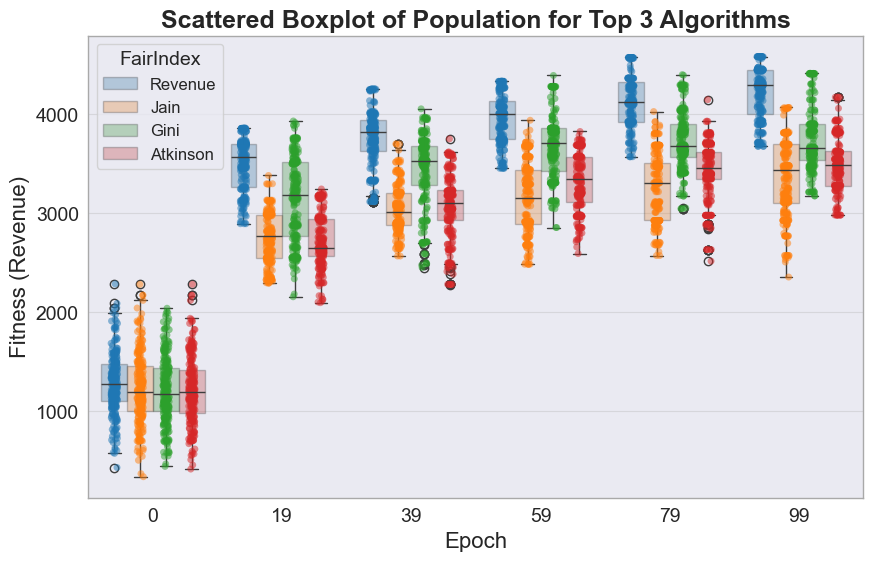

In [59]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='FairIndex',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25.pdf'))

In [ ]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Revenue',
             hue='FairIndex',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25.pdf'))

In [90]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['FairIndex', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += sorted(set(service_tsps.values()))
columns += [f"{tsp}_equity" for tsp in sorted(set(service_tsps.values()))]
summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        fitness = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        revenue = np.round(run_grouped_df.get_group(group)['Revenue'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in sorted(service_tsps.values())}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"

        frame_capacity_dict = {}
        for tsp in services_by_tsp:
            frame_capacity_dict[f"{tsp}_equity"] = f"{np.round(services_by_tsp[tsp] / scheduled_trains * 100, 2)}"

        row_data =  [algo_group[0],
                     run,
                     fitness,
                     revenue,
                     execution_time,
                     scheduled_trains,
                     np.round(delta_dt, 2),
                     np.round(delta_tt, 2),
                     *list(percentages_by_tsp.values()),
                     *list(frame_capacity_dict.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,FairIndex,Run,Fitness,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU1,RU2,RU3,RU1_equity,RU2_equity,RU3_equity
5,Revenue,1,5368.25,5368.25,27.43,24,499.0,69.0,87.5 %,87.5 %,100.0 %,58.33,29.17,12.5
6,Revenue,2,4932.54,4932.54,27.68,23,331.0,81.0,75.0 %,100.0 %,100.0 %,52.17,34.78,13.04
9,Revenue,5,4865.98,4865.98,27.63,24,322.0,89.0,81.25 %,100.0 %,100.0 %,54.17,33.33,12.5
7,Revenue,3,4421.53,4421.53,27.53,23,373.0,82.0,81.25 %,87.5 %,100.0 %,56.52,30.43,13.04
8,Revenue,4,4418.32,4418.32,27.52,23,400.0,65.0,75.0 %,100.0 %,100.0 %,52.17,34.78,13.04
3,Jain,4,3817.45,4012.75,27.93,18,173.0,59.0,68.75 %,62.5 %,66.67 %,61.11,27.78,11.11
4,Jain,5,3708.05,3915.16,28.35,20,203.0,72.0,75.0 %,75.0 %,66.67 %,60.0,30.0,10.0
0,Jain,1,3823.02,3823.43,28.45,16,142.0,45.0,62.5 %,50.0 %,66.67 %,62.5,25.0,12.5
1,Jain,2,3697.47,3766.12,27.41,17,205.0,69.0,62.5 %,62.5 %,66.67 %,58.82,29.41,11.76
2,Jain,3,3110.48,3155.68,27.43,16,138.0,35.0,56.25 %,62.5 %,66.67 %,56.25,31.25,12.5


In [70]:
frame_capacity

{'RU1': 16.0, 'RU2': 48.0, 'RU3': 24.0, 'RU4': 12.0}

In [79]:
# Supongamos que frame_capacity_target es un diccionario como:

sm = RevenueMaximization(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10
)

# Diccionario para relacionar cada servicio con el nombre de su RU.
service_tsps = {service.id: service.tsp.name for service in supply.services}

# Definir las columnas del dataframe de resumen.
base_columns = ['FairIndex', 'Run', 'Revenue', 'Execution Time (s.)',
                'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)', 'Overall Fairness']
# Ordenamos alfabéticamente los nombres de RU
ru_names = sorted(set(service_tsps.values()))
# Se añaden columnas con el porcentaje alcanzado (a nivel de RU) y
# columnas informativas con el nombre _equity para cada RU.
summary_columns = base_columns + ru_names + [f"{tsp}_equity" for tsp in ru_names]
summary_df = pd.DataFrame(columns=summary_columns)

# Agrupamos df_history por FairIndex (cada grupo corresponde a un método/algoritmo)
algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for run_label, run_group in run_grouped_df:
        # Extraer valores de la ejecución
        run = run_group['Run'].iloc[-1]
        revenue = np.round(run_group['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizar la planificación con la solución real (se ignoran los servicios no programados)
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains_array))
        delta_dt = 0.0
        delta_tt = 0.0

        # Inicializar contadores para cada RU (por ejemplo, 'RU1', 'RU2', etc.)
        services_by_tsp = {tsp: 0 for tsp in ru_names}

        # Para cada servicio del plan solicitado, si está programado se acumulan los deltas y se cuenta la RU
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            # Para el primer stop se calcula el delta en DT
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(
                sm.updated_schedule[service][departure_station][1] -
                sm.requested_schedule[service][departure_station][1]
            )
            # Para los stops intermedios se acumulan los deltas en TT
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(
                    sm.updated_schedule[service][stop][1] -
                    sm.requested_schedule[service][stop][1]
                )
            # Incrementar contador según el RU del servicio
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1

        # Calcular el porcentaje alcanzado para cada RU comparando con su capacidad marco.
        # Por ejemplo, si para 'RU1' se programaron 15 servicios y la capacidad marco es 30, se alcanza el 50%.
        percentages_by_tsp = {}
        ru_equity = {}  # Almacenará el valor numérico (por ejemplo, 50.0) para cada RU
        for tsp in ru_names:
            target = services_by_ru[tsp]  # capacidad marco del RU
            achieved = services_by_tsp[tsp]
            percentage = np.round(achieved / target * 100, 2) if target != 0 else 0.0
            percentages_by_tsp[tsp] = f"{percentage} %"
            ru_equity[tsp] = percentage

        # Calcular el índice de equidad global (Overall Fairness) usando la fórmula de Jain:
        # J = (sum(r_i)^2) / (n * sum(r_i^2))
        r_values = list(ru_equity.values())
        n = len(r_values)
        sum_r = sum(r_values)
        sum_r_sq = sum([r**2 for r in r_values])
        overall_fairness = (sum_r**2) / (n * sum_r_sq) if sum_r_sq != 0 else 0

        # Preparar la fila de datos. Se agregan:
        # - Las métricas generales
        # - Para cada RU, el porcentaje alcanzado (según el orden en ru_names)
        # - Para cada RU, se incluye una columna con el nombre <RU>_equity que muestra el mismo valor numérico
        row_data = [
            algo_group[0],            # FairIndex (método)
            run,
            revenue,
            execution_time,
            scheduled_trains,
            np.round(delta_dt, 2),
            np.round(delta_tt, 2),
            np.round(overall_fairness, 4)  # Se puede multiplicar por 100 si se prefiere porcentaje
        ]
        # Agregar los porcentajes por RU
        for tsp in ru_names:
            row_data.append(percentages_by_tsp[tsp])
        # Agregar las columnas de _equity (se puede mostrar el valor numérico)
        for tsp in ru_names:
            row_data.append(ru_equity[tsp])

        # Añadir la fila al dataframe resumen
        summary_df.loc[len(summary_df)] = row_data

# Ordenar el dataframe de salida según el Overall Fairness de forma descendente
summary_df = summary_df.sort_values('Overall Fairness', ascending=False)
display(summary_df)
print()


,FairIndex,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),Overall Fairness,RU1,RU2,RU3,RU4,RU1_equity,RU2_equity,RU3_equity,RU4_equity
8,Gini,4,3969.54,25.89,22,343.0,84.0,0.9918,100.0 %,83.33 %,83.33 %,100.0 %,100.0,83.33,83.33,100.00
0,Atkinson,1,4323.11,26.28,21,362.0,66.0,0.9856,100.0 %,75.0 %,83.33 %,100.0 %,100.0,75.00,83.33,100.00
3,Atkinson,4,4594.27,26.24,21,262.0,64.0,0.9856,100.0 %,75.0 %,83.33 %,100.0 %,100.0,75.00,83.33,100.00
4,Atkinson,5,4188.47,26.79,21,300.0,44.0,0.9856,100.0 %,75.0 %,83.33 %,100.0 %,100.0,75.00,83.33,100.00
12,Jain,3,3970.84,26.78,21,253.0,54.0,0.9856,100.0 %,75.0 %,83.33 %,100.0 %,100.0,75.00,83.33,100.00
18,Revenue,4,4581.12,25.54,21,273.0,59.0,0.9800,75.0 %,75.0 %,100.0 %,100.0 %,75.0,75.00,100.00,100.00
13,Jain,4,4403.68,26.10,20,230.0,61.0,0.9757,100.0 %,66.67 %,83.33 %,100.0 %,100.0,66.67,83.33,100.00
5,Gini,1,4404.67,26.60,21,303.0,85.0,0.9757,100.0 %,83.33 %,66.67 %,100.0 %,100.0,83.33,66.67,100.00
7,Gini,3,4109.22,26.41,20,222.0,46.0,0.9757,100.0 %,66.67 %,83.33 %,100.0 %,100.0,66.67,83.33,100.00
1,Atkinson,2,4574.15,25.86,20,174.0,60.0,0.9757,100.0 %,66.67 %,83.33 %,100.0 %,100.0,66.67,83.33,100.00


In [37]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrllll}\n\\toprule\n & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU2 & RU3 \\\\\n\\midrule\n21 & Genetic Algorithm & 2 & 4407.020000 & 25.410000 & 18 & 20.000000 & 20.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n22 & Genetic Algorithm & 3 & 4397.000000 & 25.260000 & 18 & 22.000000 & 14.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n24 & Genetic Algorithm & 5 & 4394.210000 & 26.330000 & 19 & 34.000000 & 37.000000 & 50.0 % & 80.0 % & 66.67 % & 100.0 % \\\\\n23 & Genetic Algorithm & 4 & 4359.110000 & 25.010000 & 18 & 27.000000 & 26.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n20 & Genetic Algorithm & 1 & 4348.730000 & 24.980000 & 18 & 22.000000 & 33.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n35 & Particle Swarm Optimization & 1 & 3972.600000 & 25.940000 & 17 & 48.000000 & 92.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n37 & Particle Swarm Optimization & 3 & 3951.24

In [19]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Fitness (mean and std.)
        run_fitness = run_grouped_df['Fitness'].last()
        print(f'\tFitness - Mean: {round(run_fitness.mean(), 4)} - Std: {round(run_fitness.std(), 4)}')

        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Revenue'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Atkinson status:
	Total execution time: 1.3244 s.
	Execution Time (by run) - Mean: 0.2649 s. - Std: 0.0051 s.
	Revenue - Mean: 4370.5999 - Std: 203.6767
	Scheduled Trains - Mean: 20.0 - Std: 1.0
	Max Revenue: 6096.75 - WARNING!: Scheduling all services could not be feasible

Global Gini status:
	Total execution time: 1.3002 s.
	Execution Time (by run) - Mean: 0.26 s. - Std: 0.0035 s.
	Revenue - Mean: 4196.5459 - Std: 182.047
	Scheduled Trains - Mean: 21.0 - Std: 1.0
	Max Revenue: 6096.75 - WARNING!: Scheduling all services could not be feasible

Global Jain status:
	Total execution time: 1.3277 s.
	Execution Time (by run) - Mean: 0.2655 s. - Std: 0.0068 s.
	Revenue - Mean: 4030.9153 - Std: 234.5429
	Scheduled Trains - Mean: 20.0 - Std: 1.0
	Max Revenue: 6096.75 - WARNING!: Scheduling all services could not be feasible



In [20]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'FairIndex': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

,FairIndex,Mean Execution Time (seconds),Std Execution Time (seconds),Mean Fitness (revenue),Std Fitness (revenue),Mean Scheduled Trains,Std Scheduled Trains
0,Atkinson,26.29,0.33,4370.60,203.68,20,1
1,Gini,26.28,0.35,4196.55,182.05,21,1
2,Jain,26.45,0.26,4030.92,234.54,20,1


In [40]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & Algorithm & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Genetic Algorithm & 25.400000 & 0.550000 & 4381.210000 & 25.630000 & 18 & 0 \\\\\n1 & Particle Swarm Optimization & 25.140000 & 0.480000 & 3845.480000 & 114.460000 & 17 & 0 \\\\\n2 & Ant Colony Optimization Continuous (ACOR) & 15.110000 & 0.080000 & 3691.890000 & 80.840000 & 18 & 0 \\\\\n3 & Whale Optimization Algorithm & 25.010000 & 0.290000 & 3554.280000 & 30.630000 & 15 & 0 \\\\\n4 & Differential Evolution & 25.140000 & 0.150000 & 3463.480000 & 238.220000 & 17 & 1 \\\\\n5 & Artificial Bee Colony & 50.030000 & 0.260000 & 3438.390000 & 83.710000 & 17 & 1 \\\\\n6 & Covariance Matrix Adaptation Evolution Strategy & 52.130000 & 1.880000 & 3230.210000 & 141.930000 & 15 & 0 \\\\\n7 & Grey Wolf Optimizer & 24.790000 & 0.090000 & 3112.630000 & 399.350000 & 16 & 1

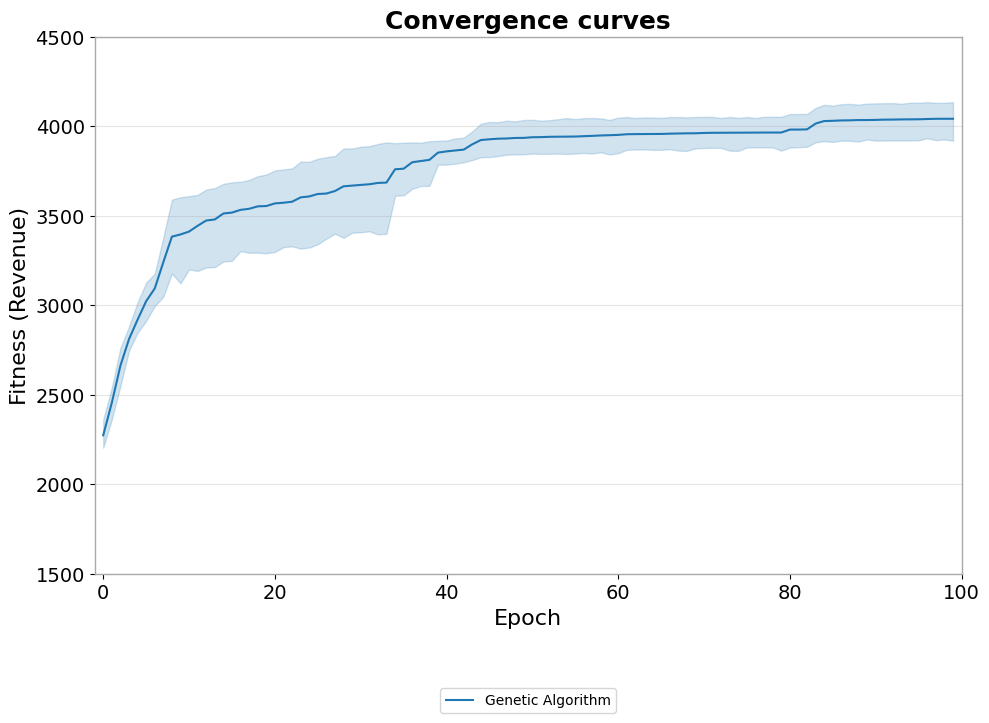

In [26]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1500,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_equity.pdf'),
              fig_size=(10, 9))

In [84]:
df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2459.878405,0.246457,"[False, True, False, True, True, True, True, F...","[1070, 1114, 1143, 867, 970, 1046, 902, 827, 9...",3.209825,0.000000,100.000000
1,1,Genetic Algorithm,1,2460.308339,0.243454,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1142, 864, 970, 1045, 898, 822, 9...",2.827368,11.915173,88.084827
2,1,Genetic Algorithm,2,2574.487027,0.243266,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1142, 872, 970, 1045, 902, 822, 9...",2.692281,16.123743,83.876257
3,1,Genetic Algorithm,3,2926.528932,0.239713,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1143, 872, 970, 1045, 902, 822, 9...",2.463509,23.250984,76.749016
4,1,Genetic Algorithm,4,3015.854710,0.239389,"[False, True, False, True, True, False, True, ...","[1061, 1109, 1144, 866, 971, 1046, 904, 827, 9...",2.223509,30.728028,69.271972


In [102]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

[1741.0809259234882,
 1748.684776735114,
 1776.928458652797,
 1787.0886195088412,
 1789.277000079085,
 1810.0148541336189,
 1819.9926110593465,
 1821.784191284223,
 1959.0674056539915,
 1965.464324500664,
 1974.408813245351,
 1974.408813245351,
 1993.9478517839375,
 1995.1817405334048,
 1995.1817405334048,
 2199.511541491974,
 2203.9916559426238,
 2203.991655942644,
 2210.439801087261,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2221.9108097656595,
 2225.2391621379447,
 2229.040605359691,
 2241.1760454529403,
 2248.2693960385377,
 2526.072256796473,
 2526.2577480508426,
 2526.257748050876,
 2533.5882980193096,
 2533.5882980193096,
 2534.321215424944,
 2536.263289652836,
 2536.9962070584693,
 2536.9962070584693,
 2538.275235491649,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2560.428120624755,
 2560.428120624755,
 2564.110568615207,
 2569.815642866672,
 2573.933454008949,
 2575.597474624795,
 2575.597474624795

In [20]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

[2607.780704168451,
 2703.21640230218,
 2911.444314465418,
 3103.973183542429,
 3220.667590931876,
 3365.2866137766955,
 3484.48609472132,
 3572.9260730745227,
 3640.073782168727,
 3669.5832622522,
 3705.136185446733,
 3794.5588181089274,
 3839.792800278671,
 3863.719004722367,
 3906.153305799562,
 3960.321202641717,
 3960.321202641717,
 4005.737551227856,
 4021.701509559909,
 4036.1238629427503,
 4036.374965155991,
 4037.255279037032,
 4047.601165890613,
 4072.3073805030704,
 4100.486496755227,
 4102.769254199621,
 4125.723121565449,
 4149.827532752619,
 4172.08849602329,
 4172.08849602329,
 4183.598501918915,
 4194.791579881078,
 4197.818016088964,
 4226.226027636936,
 4226.226027636936,
 4226.226027636936,
 4228.039611525929,
 4228.705076393186,
 4240.677771701874,
 4240.677771701874,
 4253.38097286305,
 4253.38097286305,
 4253.38097286305,
 4256.742944859372,
 4261.969159858364,
 4309.924958575424,
 4310.657875981058,
 4323.559176282795,
 4323.559176282795,
 4323.559176282795,
 432

In [21]:
print(len(algo_vals))

100


In [26]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

[2121.942526311217,
 2126.1450191909216,
 2153.200797898652,
 2172.1936191864675,
 2174.216600940857,
 2195.3208372725726,
 2204.6153864302687,
 2223.3679354022047,
 2225.390917156595,
 2244.3606160414943,
 2244.3606160414943,
 2247.4535123926985,
 2270.379052946466,
 2270.492084344696,
 2274.816620508482,
 2298.572311796074,
 2316.002237825652,
 2316.002237825652,
 2316.002237825652,
 2320.215221955512,
 2325.565748811522,
 2332.3340863078133,
 2339.717662177076,
 2345.9459463700828,
 2349.005632648977,
 2583.144820693363,
 2590.85225513937,
 2592.3896854296745,
 2596.703525330692,
 2596.703525330692,
 2599.58923714303,
 2623.8452559548505,
 2623.8452559548505,
 2628.9170645467857,
 2630.988554963445,
 2635.5254248523797,
 2649.8720529088614,
 2655.7557863545885,
 2659.9093170072138,
 2660.827594946524,
 2668.118106647075,
 2668.118106647075,
 2671.661031899009,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743

In [27]:
print(len(algo_vals))

100


In [28]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [29]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

Wilcoxon Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      3.0   
Covariance Matrix Adaptation Evolution Strategy               39.0   
Artificial Bee Colony                                          1.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                 239.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                        0.0   
Particle Swarm Optimization                          

In [30]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

P-Values Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      0.0   
Covariance Matrix Adaptation Evolution Strategy                0.0   
Artificial Bee Colony                                          0.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                   0.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                      0.000   
Particle Swarm Optimization                          

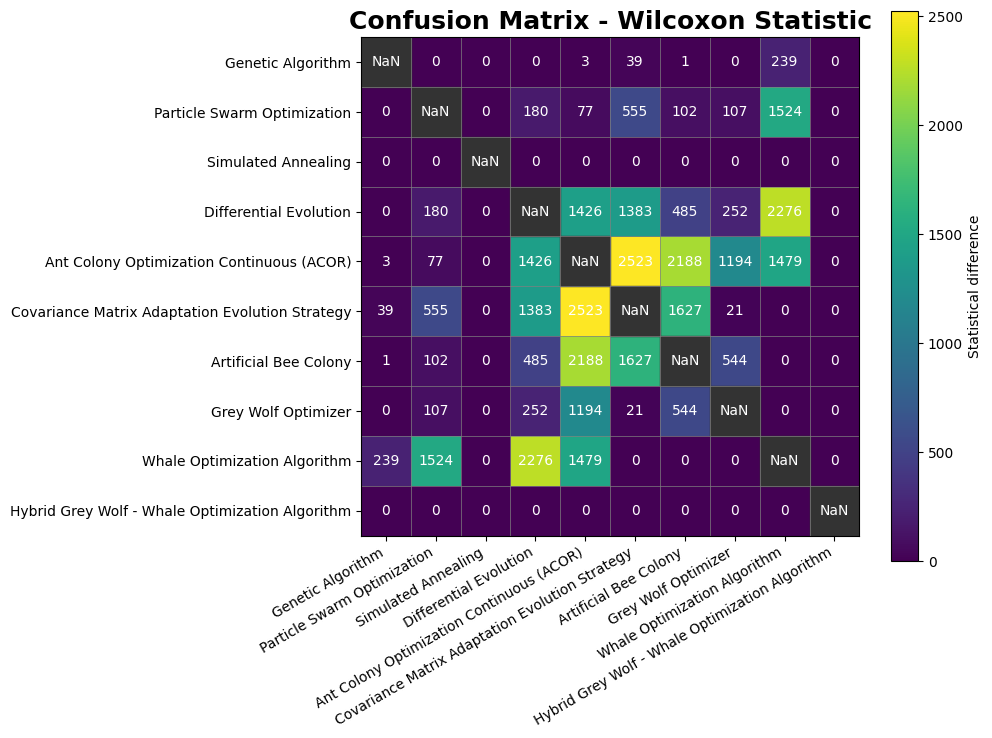

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

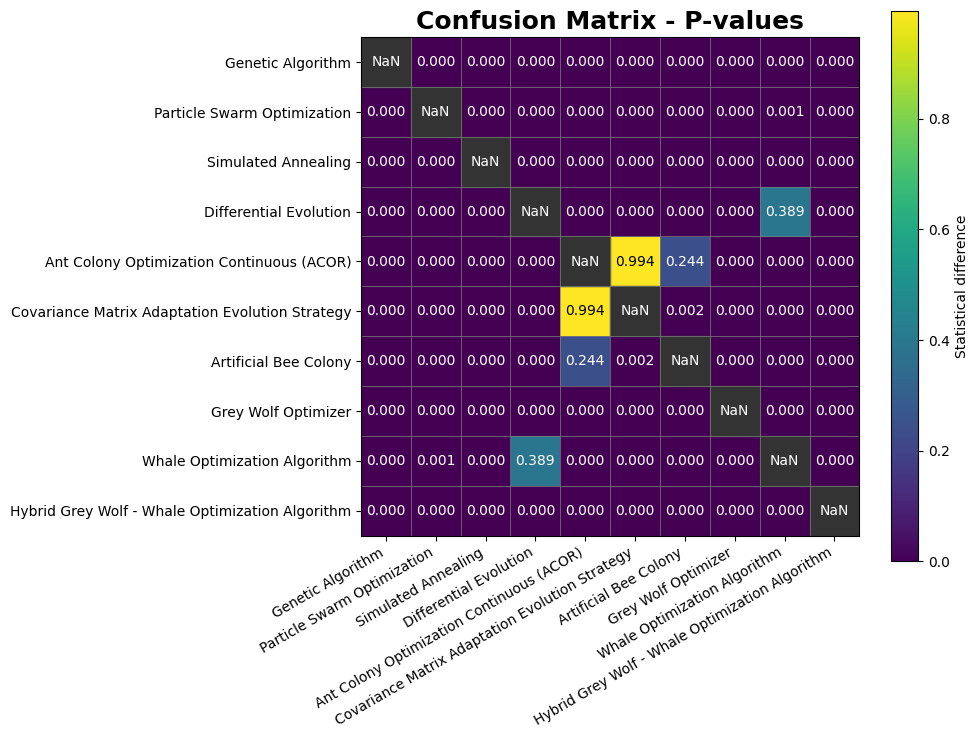

In [33]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

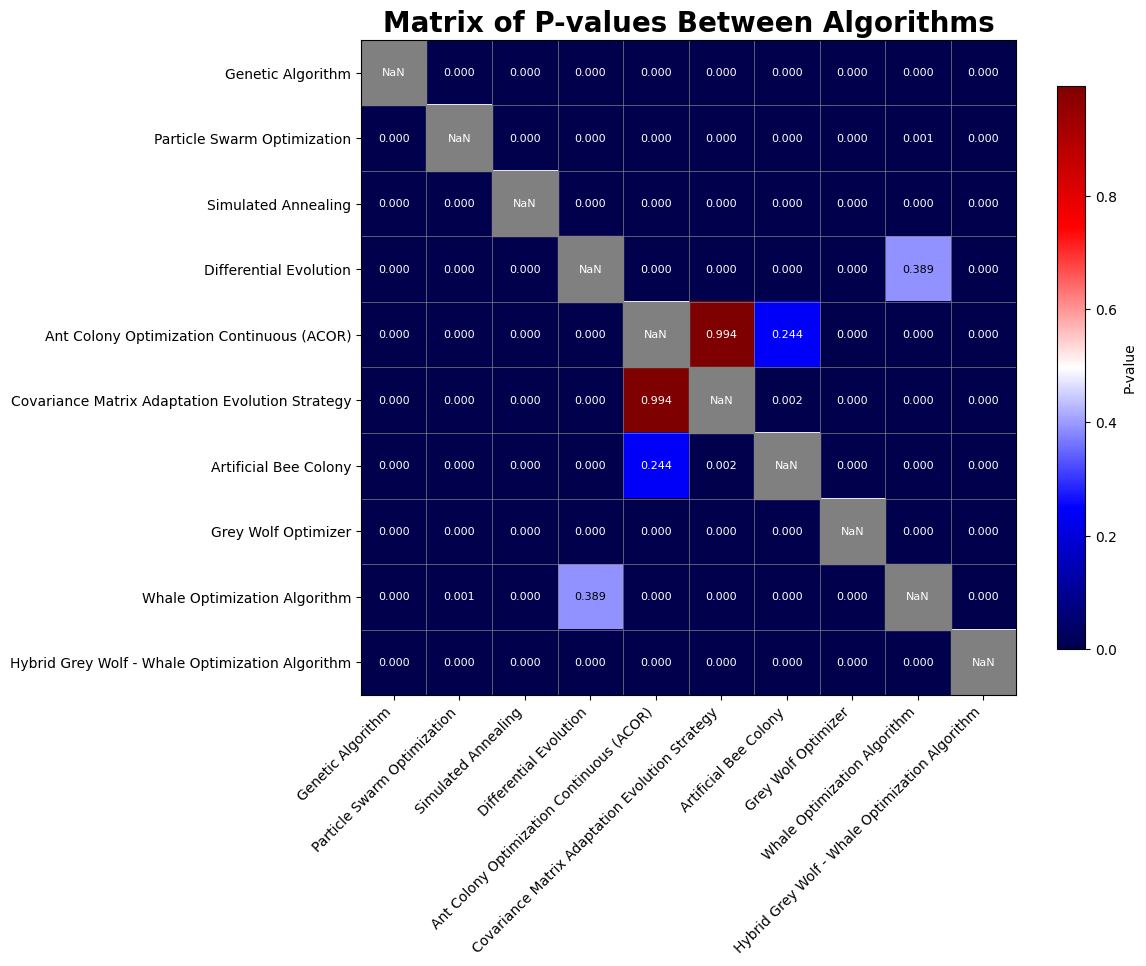

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [36]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0625


In [27]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 1
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1060 1109 1142  873  971 1046  849  826  914 1354  739  129  210  272
  531  531  631  694  943  750  184  407  467  508  902  977 1046 1098
 1139 1155 1189 1255 1307 1343  415  469  504  220  338  377  469  576
 1069 1189 1249 1288  560  614  651 1240  463  526  569 1274  896  997
 1061], Discrete: [ True  True  True False  True  True  True False  True False  True  True
 False False  True  True False False  True  True  True  True  True  True
  True]


In [28]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/mealpy/ supply_config_gsa


In [29]:
final_supply = Supply.from_yaml(supply_config_file)

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


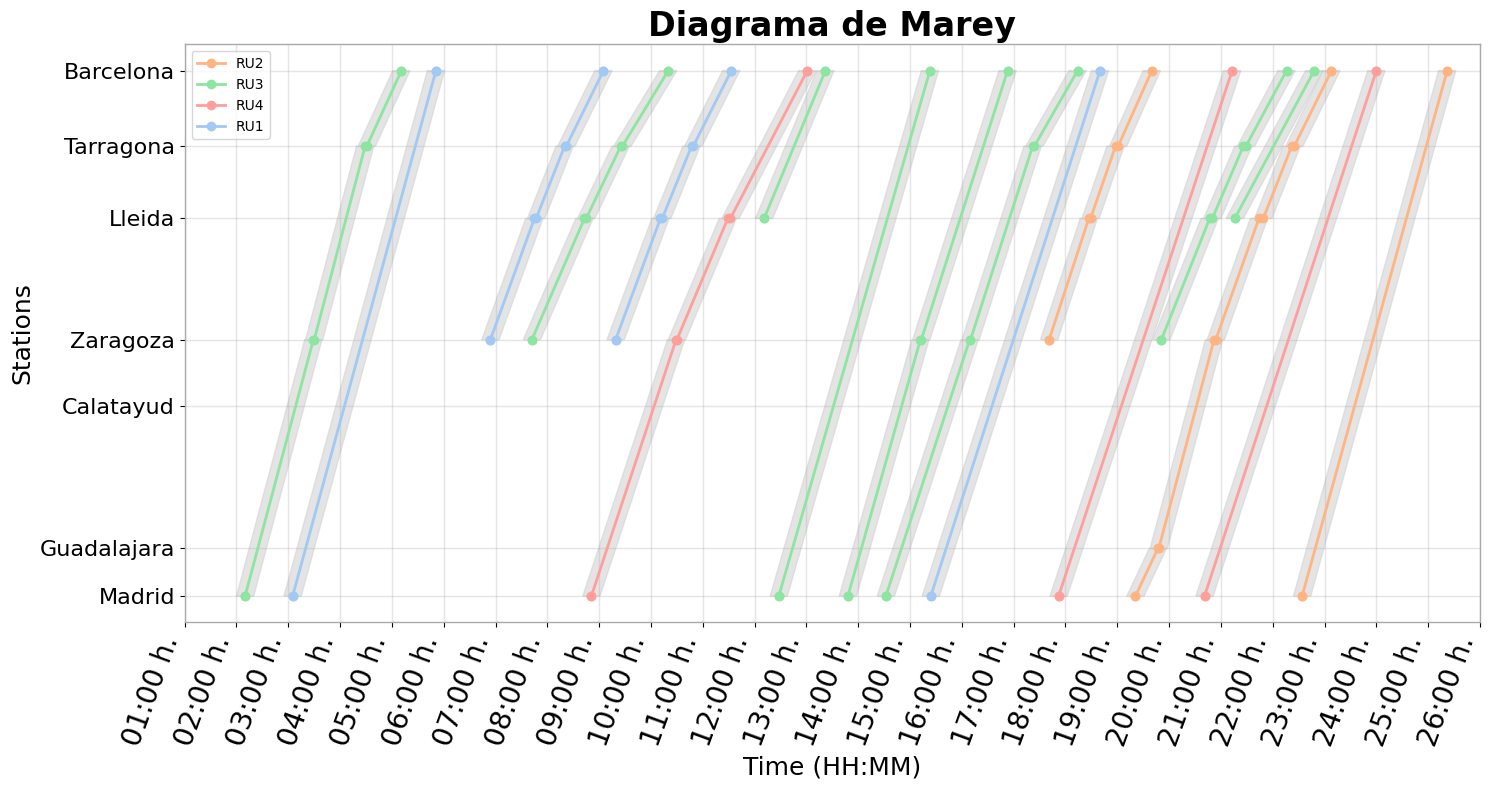

In [40]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [42]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_equity.yml')

PosixPath('../reports/mealpy/supply_config_gsa_equity.yml')

In [30]:
#!snakeviz profile.pstat